In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# parallel processing
from multiprocessing import Pool

In [4]:
# samwich routines
from samwich.dataloaders import XarrayData
from samwich.contour_functions import Contours

In [5]:
# case definition
from study import V27, neutral
from trajectory import Trajectory

# Meandering-Frame-of-Reference Analysis
Now, process output from `calculate_wake_MFoR.ipynb`

In [6]:
case = neutral(casedir='WAKEBENCH-NREL_DEBNATH_LES/neutral',
               prefix='NREL_DEBNATH_LES_20190325',
               turbine=V27)

In [7]:
wakedata = {
    '1D Gaussian (Bastankhah)': '1D_Gaussian_Bastankhah',
    '2D Gaussian': '2D_Gaussian',
    'Const area': 'Constant-Area_Contours',
    'Const momentum deficit': 'Constant-Xmom_Contours',
}
suffix = '--filtered'

In [8]:
ds = 0.25
D = case.turbine.D
ymin,ymax = -1.5*D, 1.5*D
zmin,zmax = -1.5*D, 1.5*D # relative to hub height

In [9]:
mean_utot_file = 'mean_utot_mfor.nc'
mean_wake_file = 'mean_wake_mfor.nc'
#wake_stdev_file = 'wake_stdev_mfor.nc'

## set up MFoR grid

In [10]:
# points for pcolormesh
y0 = np.arange(ymin,ymax+ds,ds)
z0 = np.arange(zmin,zmax+ds,ds)
yy,zz = np.meshgrid(y0,z0,indexing='ij')

In [11]:
# points passed to `wake.to_MFoR()`
y1 = (y0[1:] + y0[:-1]) / 2
z1 = (z0[1:] + z0[:-1]) / 2
yy,zz = np.meshgrid(y0,z0,indexing='ij')

In [12]:
yy1,zz1 = np.meshgrid(y1,z1,indexing='ij')

## mean MFoR data

In [13]:
edgelevels = -np.array([0.05,0.1,0.3]) * case.Uref
edgelevels

array([-0.435, -0.87 , -2.61 ])

In [14]:
# mean_utot = {}
# for name,outdir in wakedata.items():
#     datafile = os.path.join(case.casedir, outdir+suffix, mean_utot_file)
#     mean_utot[name] = xr.open_dataset(datafile) 

In [15]:
mean_wake = {}
for name,outdir in wakedata.items():
    datafile = os.path.join(case.casedir, outdir+suffix, mean_wake_file)
    mean_wake[name] = xr.open_dataset(datafile) 

In [16]:
displaynames = {
    '1D Gaussian (Bastankhah)': '1D Gaussian\n(Bastankhah model)',
    '2D Gaussian': '2D Gaussian fit',
    'Const area': 'Constant area\ncontours',
    'Const momentum deficit': 'Constant\nx-momentum deficit\ncontours',
}

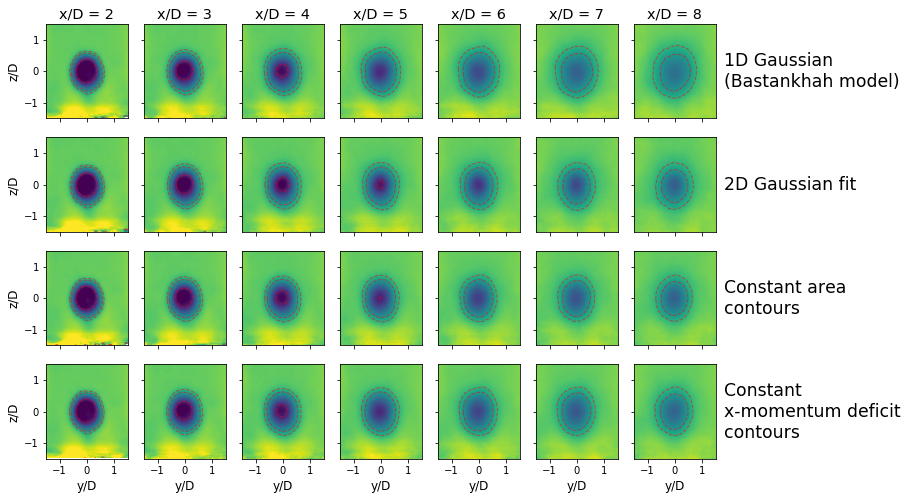

In [17]:
fig,ax = plt.subplots(nrows=len(wakedata.keys()), ncols=len(case.downstreamD),
                      sharex=True, sharey=True,
                      figsize=(12,8))
ymean,zmean = {},{}
max_deficit = {}
for i,name in enumerate(wakedata.keys()):
    vdmax = []
    y,z = [],[]
    for j,downD in enumerate(case.downstreamD):
        planedata = mean_wake[name].sel(x_D=downD)
        u_mfor = planedata['u']
        vdmax.append(u_mfor.min())
        imin,jmin = np.unravel_index(np.argmin(u_mfor[:,:]),yy1.shape)
        y.append(yy1[imin,jmin])
        z.append(zz1[imin,jmin])
        ax[i,j].pcolormesh(yy/D,zz/D,u_mfor,vmin=-3,vmax=1)
        cont = ax[i,j].contour(yy1/D,zz1/D,u_mfor,levels=sorted(edgelevels),
                               colors='r',linewidths=1,alpha=0.5)
    max_deficit[name] = np.array(vdmax)
    ymean[name] = np.array(y)
    zmean[name] = np.array(z)
    
# formatting
txt_objs = []
for i,name in enumerate(wakedata.keys()):
    txt = ax[i,-1].text(1.1, 0.5, displaynames[name], fontsize='xx-large',
                        horizontalalignment='left',verticalalignment='center',transform=ax[i,-1].transAxes)
    txt_objs.append(txt)
    ax[i,0].set_ylabel('z/D',fontsize='large')
for j,downD in enumerate(case.downstreamD):
    ax[-1,j].set_xlabel('y/D',fontsize='large')
    ax[0,j].set_title('x/D = {:g}'.format(downD),fontsize='x-large')
    
# save
fig.savefig('figures/all_wakes_MFoR.png',dpi=300,
            bbox_extra_artists=txt_objs, bbox_inches='tight')

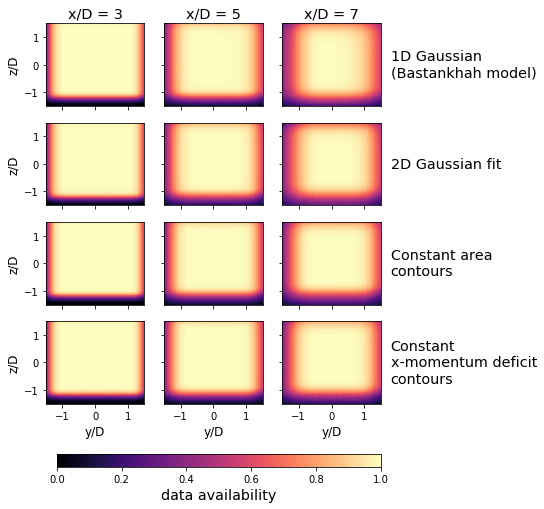

In [18]:
selected_downstream = [3,5,7]

fig,ax = plt.subplots(nrows=len(wakedata.keys()), ncols=len(selected_downstream),
                      sharex=True, sharey=True,
                      figsize=(6,7))
for i,name in enumerate(wakedata.keys()):
    for j,downD in enumerate(selected_downstream):
        planedata = mean_wake[name].sel(x_D=downD)
        avail = planedata['data_availability']
        avail = avail / np.max(avail.values)
        # plot contours
        cm = ax[i,j].pcolormesh(yy/D,zz/D,avail,vmin=0,vmax=1,cmap='magma')
        #cm = ax[i,j].pcolormesh(yy/D,zz/D,avail,vmin=0.5,vmax=1,cmap='magma')

# formatting
txt_objs = []
for i,name in enumerate(wakedata.keys()):
    txt = ax[i,-1].text(1.1, 0.5, displaynames[name], fontsize='x-large',
                        horizontalalignment='left',verticalalignment='center',transform=ax[i,-1].transAxes)
    txt_objs.append(txt)
    ax[i,0].set_ylabel('z/D',fontsize='large')
for j,downD in enumerate(selected_downstream):
    ax[-1,j].set_xlabel('y/D',fontsize='large')
    ax[0,j].set_title('x/D = {:g}'.format(downD),fontsize='x-large')
fig.subplots_adjust(bottom=0.125)
cax = fig.add_axes([0.15,0,0.75,0.025]) # left,bottom,width,height
cbar = fig.colorbar(cm,cax=cax,orientation='horizontal')
cbar.set_label('data availability',fontsize='x-large')

# save
fig.savefig('figures/all_wakes_avail_truncated.png',dpi=300,
            bbox_extra_artists=txt_objs, bbox_inches='tight')

In [19]:
def mask_by_availability(avail):
    """Determine alpha values based on the data availability count"""
    # no mask
#     avail[:] = 1.0
    # 0-100%
    avail = avail / np.max(avail.values)
    # 50-100%
#     avail[:] = (avail - 0.5)/0.5
#     avail[:] = np.maximum(0, avail)
    # 70-100%
    avail[:] = (avail - 0.7)/0.7
    avail[:] = np.maximum(0, avail)
    return avail

In [20]:
#
# FOR SOME REASON THE ALPHA DOESN'T GET UPDATE FOR THE LAST SUBPLOT...
#

# selected_downstream = [3,5,7]
# fig,ax = plt.subplots(nrows=len(wakedata.keys()), ncols=len(selected_downstream),
#                       sharex=True, sharey=True,
#                       figsize=(6,7))
# for i,name in enumerate(wakedata.keys()):
#     for j,downD in enumerate(selected_downstream):
#         planedata = mean_wake[name].sel(x_D=downD)
#         u_mfor = planedata['u']
#         avail = mask_by_availability(planedata['data_availability'])
#         # plot contours
#         cm = ax[i,j].pcolormesh(yy/D,zz/D,u_mfor,vmin=-3,vmax=1,cmap='viridis',
#                                 #antialiased=True, # SLOOOW
#                                )
#         # plot selected outlines
#         cont = ax[i,j].contour(yy1/D,zz1/D,u_mfor,levels=sorted(edgelevels),
#                                colors='r',linewidths=1)
#         # set alpha based on the number of available wake snapshots in MFoR mean
#         # - note: this works, but doesn't effectively show the data availability
#         # - note 2: for some reason the last subplot doesn't get its alpha values updated?
#         fig.canvas.draw()  # need to call this first so that get_facecolors and set_facecolors work!
#         facecolors = cm.get_facecolors()
#         for iface,alpha in enumerate(avail.values.flatten()):
#             facecolors[iface][3] = alpha
#         cm.set_facecolors(facecolors)

# # formatting
# txt_objs = []
# for i,name in enumerate(wakedata.keys()):
#     txt = ax[i,-1].text(1.1, 0.5, displaynames[name], fontsize='x-large',
#                         horizontalalignment='left',verticalalignment='center',transform=ax[i,-1].transAxes)
#     txt_objs.append(txt)
#     ax[i,0].set_ylabel('z/D',fontsize='large')
# for j,downD in enumerate(selected_downstream):
#     ax[-1,j].set_xlabel('y/D',fontsize='large')
#     ax[0,j].set_title('x/D = {:g}'.format(downD),fontsize='x-large')
# fig.subplots_adjust(bottom=0.125)
# cax = fig.add_axes([0.15,0,0.75,0.025]) # left,bottom,width,height
# cbar = fig.colorbar(cm,cax=cax,orientation='horizontal')
# cbar.set_label(r'$U - U_\infty$ [m/s]',fontsize='x-large')

# # save
# fig.savefig('figures/all_wakes_MFoR_truncated.png',dpi=300,
#             bbox_extra_artists=txt_objs, bbox_inches='tight')

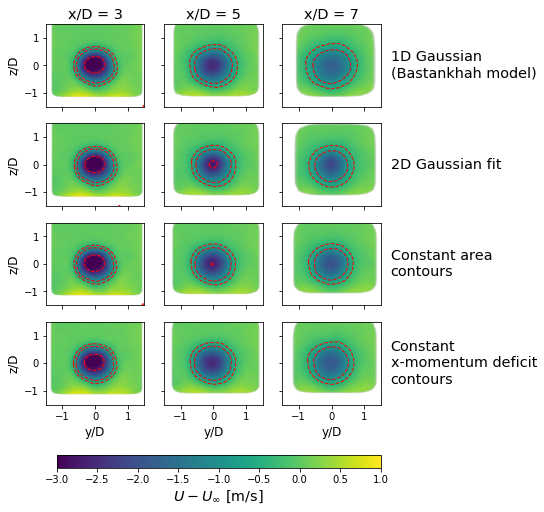

In [21]:
selected_downstream = [3,5,7]
antialiasing = True # SLOOOW if on; if off, then output png with alpha is on a blurred grid

fig,ax = plt.subplots(nrows=len(wakedata.keys()), ncols=len(selected_downstream),
                      sharex=True, sharey=True,
                      figsize=(6,7))
cmlist = []
for i,name in enumerate(wakedata.keys()):
    for j,downD in enumerate(selected_downstream):
        u_mfor = mean_wake[name].sel(x_D=downD)['u']
        # plot contours
        cm = ax[i,j].pcolormesh(yy/D,zz/D,u_mfor,vmin=-3,vmax=1,cmap='viridis',
                                antialiased=antialiasing)
        cmlist.append(cm)
        # plot selected outlines
        cont = ax[i,j].contour(yy1/D,zz1/D,u_mfor,levels=sorted(edgelevels),
                               colors='r',linewidths=1)

# formatting
txt_objs = []
for i,name in enumerate(wakedata.keys()):
    txt = ax[i,-1].text(1.1, 0.5, displaynames[name], fontsize='x-large',
                        horizontalalignment='left',verticalalignment='center',transform=ax[i,-1].transAxes)
    txt_objs.append(txt)
    ax[i,0].set_ylabel('z/D',fontsize='large')
for j,downD in enumerate(selected_downstream):
    ax[-1,j].set_xlabel('y/D',fontsize='large')
    ax[0,j].set_title('x/D = {:g}'.format(downD),fontsize='x-large')
fig.subplots_adjust(bottom=0.125)
cax = fig.add_axes([0.15,0,0.75,0.025]) # left,bottom,width,height
cbar = fig.colorbar(cmlist[0],cax=cax,orientation='horizontal')
cbar.set_label(r'$U - U_\infty$ [m/s]',fontsize='x-large')

# save
fig.savefig('figures/all_wakes_MFoR_truncated.png',dpi=300,
            bbox_extra_artists=txt_objs, bbox_inches='tight')

#
# NOW, update alpha and save masked pcolormesh plots
#
for i,name in enumerate(wakedata.keys()):
    for j,downD in enumerate(selected_downstream):
        avail = mean_wake[name].sel(x_D=downD)['data_availability']
        alphas = mask_by_availability(avail)
        # set alpha based on the number of available wake snapshots in MFoR mean
        # - note: this works, but doesn't effectively show the data availability
        cm = cmlist.pop(0)
        facecolors = cm.get_facecolors()
        for iface,alpha in enumerate(alphas.values.flatten()):
            facecolors[iface][3] = alpha
        cm.set_facecolors(facecolors)
fig.savefig('figures/all_wakes_MFoR_truncated_alpha.png',dpi=300,
            bbox_extra_artists=txt_objs, bbox_inches='tight')

### max deficit

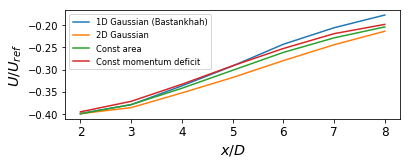

In [22]:
fig,ax = plt.subplots(figsize=(6,2))
for name in wakedata.keys():
    ax.plot(case.downstreamD, max_deficit[name]/case.Uref, label=name)
ax.set_xlabel(r'$x/D$',fontsize='x-large')
ax.set_ylabel(r'$U/U_{ref}$',fontsize='x-large')
ax.tick_params(axis='x',labelsize='large')
ax.legend(fontsize='small')
fig.savefig('figures/wake_VD_MFoR.png',dpi=150,bbox_inches='tight')

In [23]:
recovery = pd.DataFrame(max_deficit,index=case.downstreamD).drop(columns='1D Gaussian (Bastankhah)')
recovery

,2D Gaussian,Const area,Const momentum deficit
2,-3.473266,-3.477240,-3.437804
3,-3.355310,-3.295652,-3.231655
4,-3.066775,-2.975520,-2.897050
5,-2.764984,-2.623576,-2.534811
6,-2.433724,-2.272802,-2.196436
7,-2.122710,-1.987635,-1.905341
8,-1.857702,-1.773146,-1.723387


In [24]:
recovery.max(axis=1) - recovery.min(axis=1)

2    0.039436
3    0.123655
4    0.169724
5    0.230173
6    0.237288
7    0.217369
8    0.134315
dtype: float64

### contour area evolution
from mean wake data

In [25]:
columns = pd.MultiIndex.from_product([wakedata.keys(), edgelevels])
wake_area = pd.DataFrame(index=case.downstreamD,columns=columns)
for name in wakedata.keys():
    for edgelevel in edgelevels:
        for downD in case.downstreamD:
            planedata = mean_wake[name].sel(x_D=downD).to_array()
            cnt = Contours(yy1,zz1,planedata[0,:,:])
            paths = cnt.get_closed_paths(edgelevel)
            # filter out short paths
#             paths = [ p for p in paths if len(p) > 20 ]\
            # filter out paths that are too far from the origin (in the MFoR)
            def dist_from_origin(p):
                xp,yp = cnt.to_coords(p)
                x0 = np.mean(xp)
                y0 = np.mean(yp)
                return np.sqrt(x0**2 + y0**2)
            paths = [ p for p in paths if dist_from_origin(p) < case.turbine.D ]
            # DEBUG
#             #if (edgelevel == -.435) and (downD == 5):
#             #if (edgelevel == -0.87) and (downD == 5):
#             #if (edgelevel == -2.61) and (downD == 5):
#             if (name == '1D Gaussian (Bastankhah)') and (edgelevel == -.435) and (downD in [4,5,6]):
#                 plt.figure()
#                 plt.pcolormesh(yy,zz,planedata[0,:,:],cmap='bone')
#                 plt.contour(yy1,zz1,planedata[0,:,:],sorted(edgelevels),colors='r')
#                 for p in paths:
#                     xp,yp = cnt.to_coords(p,closed=True)
#                     plt.plot(xp,yp)
#                 plt.title(name)
            # now calculate area if there are viable contours that remain
            if len(paths) > 0:
                assert (len(paths)==1)
                # get coordinates from selected path
                coords = cnt.to_coords(paths[0],array=True)
                # calculate area from extracted coordinates
                A = cnt.calc_area(coords=coords)
                print(name,downD,len(paths[0]),A)
                wake_area.loc[downD,(name,edgelevel)] = A
            else:
                break

1D Gaussian (Bastankhah) 2 218 977.234375
1D Gaussian (Bastankhah) 3 222 1076.890625
1D Gaussian (Bastankhah) 4 218 1200.796875
1D Gaussian (Bastankhah) 5 240 1309.015625
1D Gaussian (Bastankhah) 6 245 1409.84375
1D Gaussian (Bastankhah) 7 264 1505.734375
1D Gaussian (Bastankhah) 8 259 1545.15625
1D Gaussian (Bastankhah) 2 178 784.296875
1D Gaussian (Bastankhah) 3 188 809.015625
1D Gaussian (Bastankhah) 4 172 832.59375
1D Gaussian (Bastankhah) 5 198 802.84375
1D Gaussian (Bastankhah) 6 188 848.640625
1D Gaussian (Bastankhah) 7 189 799.4375
1D Gaussian (Bastankhah) 8 190 735.546875
1D Gaussian (Bastankhah) 2 110 324.109375
1D Gaussian (Bastankhah) 3 90 212.453125
1D Gaussian (Bastankhah) 4 71 99.234375
2D Gaussian 2 214 971.875
2D Gaussian 3 212 1065.953125
2D Gaussian 4 220 1130.546875
2D Gaussian 5 217 1172.015625
2D Gaussian 6 231 1184.125
2D Gaussian 7 228 1170.40625
2D Gaussian 8 230 1151.453125
2D Gaussian 2 182 788.03125
2D Gaussian 3 178 801.75
2D Gaussian 4 172 778.640625
2D Ga

In [26]:
wake_area

1D Gaussian (Bastankhah)                   2D Gaussian                    \
                    -0.435   -0.870   -2.610      -0.435   -0.870   -2.610   
2                  977.234  784.297  324.109     971.875  788.031  321.891   
3                  1076.89  809.016  212.453     1065.95   801.75  211.016   
4                   1200.8  832.594  99.2344     1130.55  778.641  121.359   
5                  1309.02  802.844      NaN     1172.02  734.844  36.0781   
6                  1409.84  848.641      NaN     1184.12  710.812      NaN   
7                  1505.73  799.438      NaN     1170.41  641.266      NaN   
8                  1545.16  735.547      NaN     1151.45  576.531      NaN   

  Const area                   Const momentum deficit                    
      -0.435   -0.870   -2.610                 -0.435   -0.870   -2.610  
2    959.703  775.453  330.656                995.641  793.828  326.609  
3    1053.98  798.172  213.375                1088.22  824.281  205.344  
4    1111.88  793.312  113.828                1166.22   828.75  92.1875  
5    1141.61  773.312  3.98438                1210.91  807.844      NaN  
6    1173.41  733.734      NaN                1264.14  779.188      NaN  
7    1158.45  663.844      NaN                1269.77  721.531      NaN  
8    1127.81  605.844      NaN                1175.59      646      NaN

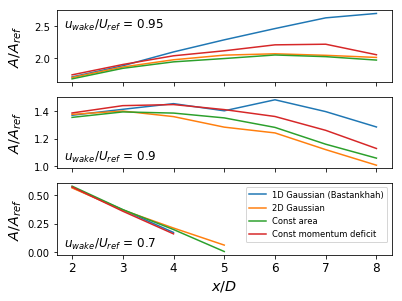

In [27]:
fig,ax = plt.subplots(nrows=len(edgelevels),sharex=True,figsize=(6,4.5))
for name in wakedata.keys():
    for axi,edgelevel in zip(ax,edgelevels):
        axi.plot(case.downstreamD, wake_area[(name,edgelevel)]/case.turbine.rotor_area, label=name)

for axi,edgelevel in zip(ax,edgelevels):
    axi.set_ylabel(r'$A/A_{ref}$',fontsize='x-large')
    vd = (case.Uref + edgelevel)/case.Uref
    displaystr = r'$u_{wake}/U_{ref}$ = ' + '{:g}'.format(vd)
    if axi==ax[0]:
        axi.text(0.02, 0.9, displaystr, fontsize='large',
                 horizontalalignment='left',verticalalignment='top',transform=axi.transAxes)
    else:
        axi.text(0.02, 0.05, displaystr, fontsize='large',
                 horizontalalignment='left',verticalalignment='bottom',transform=axi.transAxes)

fig.align_ylabels()
ax[-1].tick_params(axis='x',labelsize='large')
ax[-1].set_xlabel(r'$x/D$',fontsize='x-large')
ax[-1].legend(loc='best',fontsize='small')

fig.savefig('figures/wake_areas_MFoR.png',dpi=150,bbox_inches='tight')

In [28]:
norm_wake_area = wake_area.stack().xs(edgelevels[0],level=1) / case.turbine.rotor_area
norm_wake_area

,1D Gaussian (Bastankhah),2D Gaussian,Const area,Const momentum deficit
2,1.70679,1.69743,1.67618,1.73894
3,1.88085,1.86175,1.84084,1.90064
4,2.09726,1.97456,1.94195,2.03687
5,2.28627,2.04699,1.99389,2.11492
6,2.46237,2.06814,2.04942,2.20789
7,2.62985,2.04418,2.0233,2.21772
8,2.6987,2.01108,1.96979,2.05324


In [29]:
norm_wake_area['Const momentum deficit'] - norm_wake_area['Const area']

2    0.0627669
3    0.0597923
4    0.0949144
5     0.121031
6     0.158473
7     0.194414
8    0.0834526
dtype: object

In [30]:
norm_wake_area.max()

1D Gaussian (Bastankhah)    2.698702
2D Gaussian                 2.068141
Const area                  2.049420
Const momentum deficit      2.217717
dtype: float64

### mean trajectory <font color='red'>?</font>

Text(0.5, 0, '$x/D$')

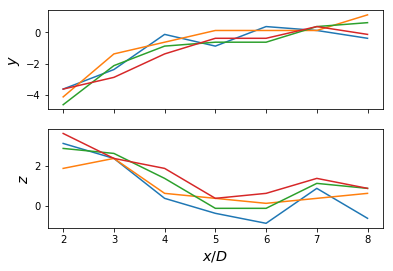

In [31]:
fig,ax = plt.subplots(nrows=2,sharex=True)
for name in wakedata.keys():
    ax[0].plot(case.downstreamD, ymean[name], label=name)
    ax[1].plot(case.downstreamD, zmean[name], label=name)
ax[0].set_ylabel(r'$y$',fontsize='x-large')
ax[1].set_ylabel(r'$z$',fontsize='x-large')
ax[1].set_xlabel(r'$x/D$',fontsize='x-large')


In [32]:
mmmkay

NameError: name 'mmmkay' is not defined

## stdev MFoR data

In [ ]:
wake_stdev = {}
for name,outdir in wakedata.items():
    datafile = os.path.join(case.casedir, outdir+suffix, wake_stdev_file)
    wake_stdev[name] = xr.open_dataset(datafile)

In [ ]:
fig,ax = plt.subplots(nrows=len(wakedata.keys()), ncols=len(case.downstreamD),
                      sharex=True, sharey=True,
                      figsize=(11,8))
irow = 0
max_stdev = {}
for name in wakedata.keys():
    stdmax = []
    for i,downD in enumerate(case.downstreamD):
        # plot high turbulence region
        planedata = wake_stdev[name].sel(x_D=downD).to_array()
        stdmax.append(planedata.min())
        ax[irow,i].pcolormesh(yy/D,zz/D,planedata[0,:,:])
        # plot velocity deficit edge from before
        planedata = mean_wake[name].sel(x_D=downD).to_array()
        ax[irow,i].contour(yy1/D,zz1/D,planedata[0,:,:],levels=sorted(edgelevels),colors='r',alpha=0.5)
    max_stdev[name] = np.array(stdmax)
    irow += 1

# formatting
for i,name in enumerate(wakedata.keys()):
    ax[i,-1].text(1.1, 0.5, name, fontsize='xx-large',
                  horizontalalignment='left',verticalalignment='center',transform=ax[i,-1].transAxes)
    ax[i,0].set_ylabel('z/D',fontsize='large')
for j,downD in enumerate(case.downstreamD):
    ax[-1,j].set_xlabel('y/D',fontsize='large')
    ax[0,j].set_title('x/D = {:g}'.format(downD),fontsize='x-large')